# Anális de datos exploratorio 
## Caso de estudio: Neumonía en el NIH chest X-ray dataset
por: Juan Irving Vasquez


*An Exploratory Data Analisys (EDA) performs several statistics about the dataset in order to take better decision at the machine learning estage. Some commons statistics are to compute the patient distribution as well as the disease's correlations.*

Una de las primeras cosas o posiblemente la primer cosa que tenemos que hacer en un proceso de anális o inferencia, es conocer el conjunto de datos al que nos efrentamos, incluso aunque sea un conjunto de datos que nosotros hayamos creado existe mucha información que podemos extraer y que posiblemente no hemos tomado en cuenta.

Un análisis de datos exploratorio (EDA por sus siglás en inglés) calcula diversas estadísticas acerca del conjunto de datos a fin de tomar mejores decisiones en la etapa de anális o aprandizaje máquina. Algunas estadísticas comunes son la distribución de de la población de estudio (pacientes) asi como las etiquetas (enfermedades) y correlaciones entre ellas. En muchos casos realizar un EDA previo permitirá disminuir el tiempo de desarrollo debido a que se seleccionaran algoritmos y estrategias adecuadas. Por otro lado, un buen EDA también permite adquirir información sobre las limitaciones de los algoritmos propuestos. De forma general podemos seguir el flujo propuesto Cox.

![image.png](edaflow.PNG)

En este notebook se realiza un EDA del conjunto de datos NIH chest X-ray dataset con interés particular en los datos recolectados de neumonía. Debido a que en el siguiente estudio se realizá un sistema para la detección de neumonía de utilizando técnicas de aprendizaje profundo.



In [1]:
# Cargar paquetes necesarios
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from collections import defaultdict 
import pydicom

## fix random_state for reproducibility
random_state = 42

## Funciones adicionales

*I wrote some auxiliary fuctions to perform the EDA*

A continuación se presentan varias funciones auxiliares

In [2]:
# function to get unique values
def unique(list1):
    # intilize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def splitClasses(string):
    return string.split('|')

def getAllDifferentClasses(dataframe, column):
    labels = all_xray_df[column].unique()
    anidada = [splitClasses(cs) for cs in labels]
    labels = [l for lista in anidada for l in lista]
    return unique(labels)

def getCountsDataFrame(df, column, labels):
    col = df[column]
    diccionario  = {l:0 for l in labels}
    for element in col:
        lsplit = splitClasses(element)
        #print(lsplit)
        for l_individual in lsplit:
            #print(diccionario[l_individual])
            diccionario[l_individual] += 1
    return diccionario

def getCountsColumn(col, labels):
    diccionario  = {l:0 for l in labels}
    for element in col:
        lsplit = splitClasses(element)
        #print(lsplit)
        for l_individual in lsplit:
            #print(diccionario[l_individual])
            diccionario[l_individual] += 1
    return diccionario
        
def plotCounts(counts_dict, graphWidth, name='Counts'):
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    plt.xticks(rotation='vertical')
    plt.title(name)
    plt.bar(*zip(*counts_dict.items()), color=['red', 'green', 'blue', 'cyan', 'black'])
    plt.show()
    
def countPairs(df, column, la, lb):
    col = df[column]
    suma = 0
    for element in col:
        lsplit = splitClasses(element)
        if la in lsplit and lb in lsplit:
            suma += 1
    return suma

def coOcurrencia(dataframe, column):
    #labelsmix = dataframe[column].unique()
    labels = getAllDifferentClasses(dataframe, column)
    n_labels = len(labels)
    matrix_coo = np.zeros((n_labels,n_labels))
    
    for i, la in enumerate(labels):
        max_count = 0
        normalize = False;
        for j, lb in enumerate(labels):
            #search pair (la, lb)
            count = countPairs(dataframe, 'Finding Labels', la, lb)
            matrix_coo[i][j] = count
            if count > max_count:
                max_count = count
                normalize = True
        if normalize:
            matrix_coo[i] = matrix_coo[i] * (1/max_count)
    return labels, matrix_coo

def plotCorrelationMatrix(labels, matrix, graphWidth, title='Correlation Matrix for'):
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(matrix, fignum = 1)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(title, fontsize=15)
    plt.show()

## Datos del NIH 

El conjunto de datos *NIH Chest X-ray* esta compuesto de 112,120 imágenes de rayos-x etiquetas provenientes de 30,805 pacientes. El objetivo de este dataset es promover el diagnóstico asistido por computadora (CAD por sus siglas en inglés) en afectaciones que sean detectables en imágenes de rayos X. Las etiquetas fueron obtenidas de forma automática mediante técnicas de procesamiento del lenguaje natural. Es importante tomar en cuanta que se espera que las etiquetas sean al menos 90 % certeras. Más detalles del conjunto de datos se pueden encontrar en las siguientes referencias:

- Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8Hospital-ScaleChestCVPR2017_paper.pdf

- NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community



In [4]:
# Listamos el contenido del folder que contiene los datos
print(os.listdir('/data'))

['FAQ_CHESTXRAY.pdf', 'ARXIV_V5_CHESTXRAY.pdf', 'images_009', 'images_011', 'images_003', 'images_004', 'README_CHESTXRAY.pdf', 'images_012', 'images_007', 'images_005', 'train_val_list.txt', 'BBox_List_2017.csv', 'images_001', 'images_008', 'LOG_CHESTXRAY.pdf', 'images_006', 'test_list.txt', 'images_002', 'images_010', 'Data_Entry_2017.csv']


### Cargar datos

El conjunto de datos separa las imagenes de las etiquetas. Estas últimas se encuentran en un archivo separado por comas, el cual leeremos a continuación.

In [6]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
nRow, nCol = all_xray_df.shape
print(f'There are {nRow} rows and {nCol} columns')

all_xray_df.sample(10)

There are 112120 rows and 12 columns


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
105234,00028255_000.png,No Finding,0,28255,33,F,PA,2504,2992,0.139000,0.139000,NaN
45261,00011605_006.png,Atelectasis,6,11605,43,F,AP,2500,2048,0.168000,0.168000,NaN
2516,00000649_000.png,Pleural_Thickening,0,649,58,M,PA,2500,2048,0.168000,0.168000,NaN
51735,00013063_002.png,Effusion|Mass,2,13063,72,M,PA,2992,2991,0.143000,0.143000,NaN
34484,00009082_000.png,No Finding,0,9082,73,M,PA,2500,2048,0.168000,0.168000,NaN
25398,00006682_002.png,No Finding,2,6682,38,M,PA,2992,2991,0.143000,0.143000,NaN
91619,00022837_050.png,No Finding,50,22837,66,M,PA,2021,2021,0.194311,0.194311,NaN
6931,00001836_117.png,Atelectasis,117,1836,50,F,AP,2500,2048,0.168000,0.168000,NaN
98520,00026037_001.png,Infiltration,1,26037,24,M,PA,2992,2991,0.143000,0.143000,NaN
95415,00025082_005.png,Pneumothorax,5,25082,60,F,PA,2992,2991,0.143000,0.143000,NaN


### Tipos de datos

El tipo de dato es importante para saber que operaciones podemos realizar sobre ellos. Revisaremos los datos que se encuentran en el CSV y las imágenes las revisaremos más tarde.



In [7]:
print('Tipos de datos: \n', all_xray_df.dtypes)

print('Tipo de datos de las etiquetas: ', type(all_xray_df['Finding Labels'][0]))

Tipos de datos: 
 Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
Unnamed: 11                    float64
dtype: object
Tipo de datos de las etiquetas:  <class 'str'>


OBSERVACIONES: El archivo contien variables numéricas y categóricas (cuatitativas y cualitativas). El tipo de dato de las etiquetas es cadena de texto, además todas las etiquetas se encuentran en una sola cadena separadas por el símbolo '|'. 

### Crear columnas binarias

El conjunto de datos de NIH contiene ejemplos de diversas enfermedades, todas estas estan reportadas en la columna *Findings Labels*. Pero dado que nuestro interés está en la detección de neumonía se agregará una columna binaria para cada enfermedad, esto facilita el análisis y entrenamiento.

In [9]:

## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
85329,00021035_013.png,Infiltration|Pleural_Thickening,13,21035,34,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
828,00000202_000.png,No Finding,0,202,66,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25313,00006663_001.png,Atelectasis|Effusion,1,6663,48,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Estudio de la población

La población sobre la que se tienen datos es de suma importancia ya que provee los alcances y limitaciones de cualquier algoritmo que se desee desarrollar sobre estos datos. A continuación se calculan las siguientes estadisticas tanto para la población completa como para la que presenta neumonía:
- Distribución de edades
- Distribución del género

### Distribución de las edades

--- Complete population ---
Average poblation age:  46.90146271851587
Younger patient: 1
Older patient 414
--- Population with Pneumonia ---
Average poblation age:  44.92732354996506
Younger patient: 2
Older patient 412


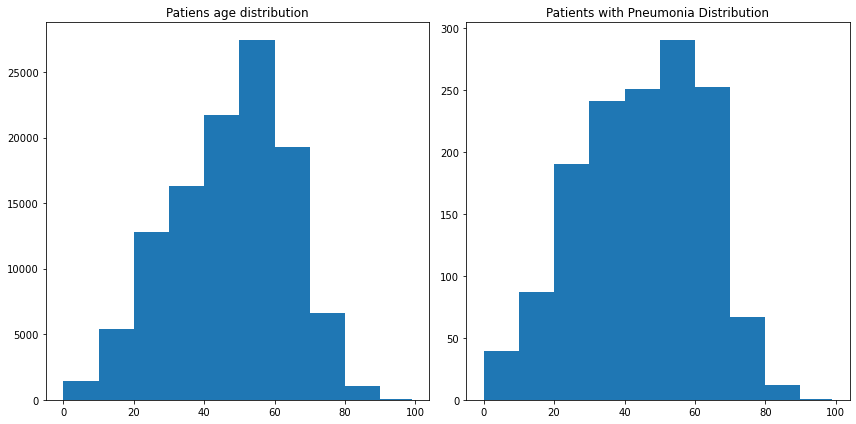

In [11]:
# Get average Age
ages = all_xray_df['Patient Age']

average_age = np.average(ages)
print("--- Complete population ---")
print("Average poblation age: ", average_age)
print("Younger patient:", np.min(ages))
print("Older patient", np.amax(ages))

fig = plt.subplots(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.subplots_adjust(hspace = 1.0)
ax = plt.hist(ages, bins=[0,10,20,30,40,50,60,70,80,90,99])
plt.title('Patiens age distribution')
plt.tight_layout()

with_pneumonia = np.array(all_xray_df['Pneumonia'])
indexes = np.where(with_pneumonia==1)[0]
ages_pneu = ages[list(indexes)]

print("--- Population with Pneumonia ---")
print("Average poblation age: ", np.average(ages_pneu))
print("Younger patient:", np.min(ages_pneu))
print("Older patient", np.amax(ages_pneu))

plt.subplot(1, 2, 2)
plt.subplots_adjust(hspace = 1.0)
ax = plt.hist(ages_pneu, bins=[0,10,20,30,40,50,60,70,80,90,99])
plt.title('Patients with Pneumonia Distribution')
plt.tight_layout()

OBSERVATION: *We can observe that the patients age with pneumonia distribution follows a similar distribution with respect to the whole study population. I detected an outlier in the maximum age, it is maybe a labeling error.*

OBSERVACION: La distribución de las edades de los pacientes clasificados con neumonía es similar a la distribución de la población completa. Además, las edades leídas tienen unos outliers, dado que está registrada una edad de 414 años en la población de estudio. 

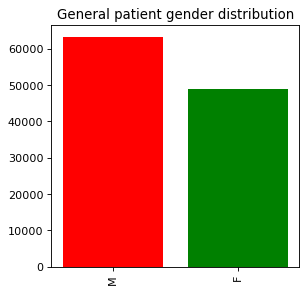

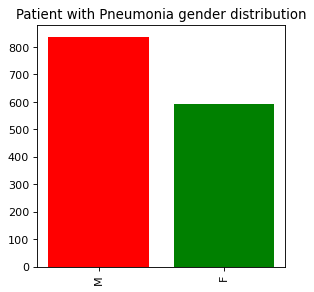

In [12]:
# Plot gender distribution
column = 'Patient Gender'
labels = getAllDifferentClasses(all_xray_df, column)
dict_counts = getCountsDataFrame(all_xray_df, column, labels)
plotCounts(dict_counts, 4, name = "General patient gender distribution")

gender_with_pneu = np.array(all_xray_df[column])[list(indexes)]
dict_counts = getCountsColumn(gender_with_pneu, labels)
plotCounts(dict_counts, 4, name = "Patient with Pneumonia gender distribution")

OBSERVATION: *In both cases, for the whole dataset and for patiends with pneumonia, the number of male examples is higher than female examples.*

OBSERVACION: Tanto para la población completa como la que tiene neumonía, el numeró de ejemplos para masculinos es mayor que la de femeninos.

### Distribución de las enfermedades halladas

Se muestra la distribución de las enfermedades detectadas. 


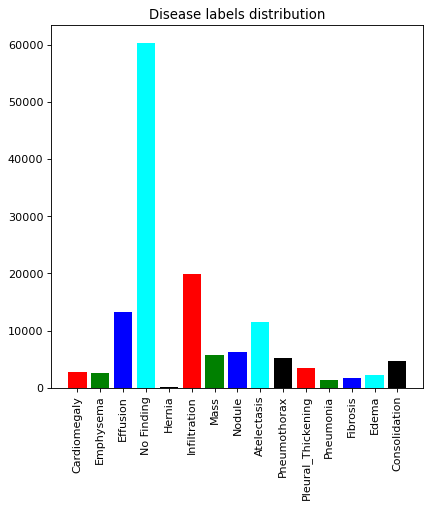

Neumonia Cases: 1431
No neumonia Cases: 110689


In [13]:
# Plot disease labels distribution
column = 'Finding Labels'
labels = getAllDifferentClasses(all_xray_df, column)
dict_counts = getCountsDataFrame(all_xray_df, column, labels)

plotCounts(dict_counts, 6, name= 'Disease labels distribution')

print('Neumonia Cases:', dict_counts['Pneumonia'])
print('No neumonia Cases:', nRow - dict_counts['Pneumonia'])

*OBSERVATION: The number of pneumonia cases is much less than the number of total examples. The largest number is for cases with no findings*

OBSERVACION: La cantidad de ejemplos de neumonia es mucho menos que los ejemplos del conjunto de datos. El mayor numero de casos reportados es de aquellos que no tienen hallazgos

### Distribución de las posiciones de vista

Se muestra la distribución de las posiciones desde donde se tomaron los rayos x (posicion de vista).

['PA', 'AP']


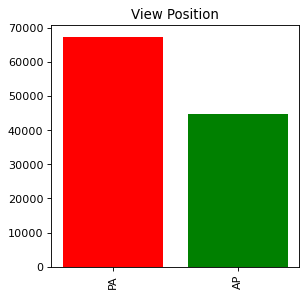

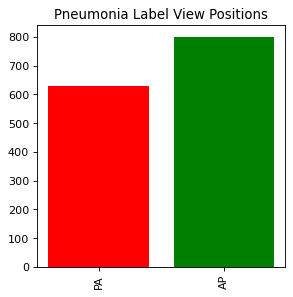

Anteroposterior images: 801


In [14]:
column = 'View Position'
labels = getAllDifferentClasses(all_xray_df, column)
print(labels)
dict_counts = getCountsDataFrame(all_xray_df, column, labels)
plotCounts(dict_counts, 4, name= 'View Position')

views_with_pneu = np.array(all_xray_df[column])[list(indexes)]
dict_counts = getCountsColumn(views_with_pneu, labels)
plotCounts(dict_counts, 4, name = "Pneumonia Label View Positions")

print("Anteroposterior images:", dict_counts['AP'])

*OBSERVATION: The number of AP images for pneumonia cases is higher than the number of AP. Contrary to the whole population where PA is higher than AP.*


AP, anteroposterior: Proyección en la que el paciente está situado de frente a la parte generadora o a la fuente de energía, en el momento de la adquisición de una imagen.
PA, Posteroanterior: Proyección en la que el paciente está situado de espalda a la parte generadora o fuente de energía.

### Número de enfermedades detectadas

defaultdict(<function <lambda> at 0x7f662156c8c0>, {1: 30963, 2: 14306, 4: 1247, 3: 4856, 5: 301, 6: 67, 7: 16, 8: 1, 9: 2})


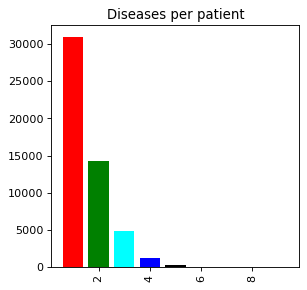

In [16]:
labelsmix = all_xray_df['Finding Labels']
diseases_per_row = [len(element) for element in labelsmix]
diseases_per_patient = defaultdict(lambda: 0)
no_disease = 'No Finding'
for diseases in labelsmix:
    lbls = splitClasses(diseases)
    #print(lbls)
    if no_disease not in lbls:
        diseases_per_patient[len(lbls)] += 1
        
print(diseases_per_patient)

plotCounts(diseases_per_patient, 4, name = 'Diseases per patient')

### Comorbilities

In [17]:
# Comorbid
column = 'Finding Labels'
labels = getAllDifferentClasses(all_xray_df, column)
all_xray_df[all_xray_df.Pneumonia==1][labels].sum()

Cardiomegaly            41.0
Emphysema               23.0
Effusion               269.0
No Finding               0.0
Hernia                   3.0
Infiltration           605.0
Mass                    71.0
Nodule                  70.0
Atelectasis            262.0
Pneumothorax            41.0
Pleural_Thickening      48.0
Pneumonia             1431.0
Fibrosis                11.0
Edema                  340.0
Consolidation          123.0
dtype: float64

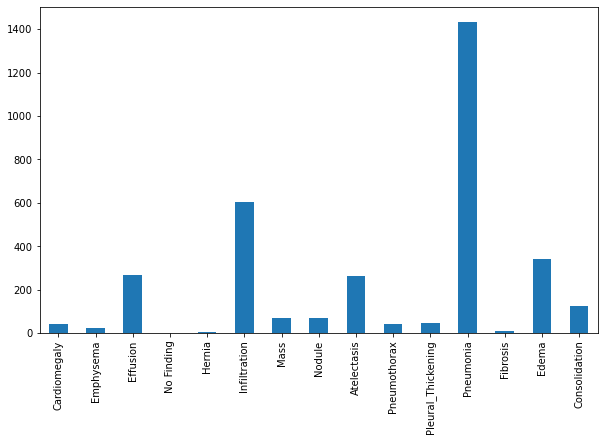

In [18]:
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df.Pneumonia==1][labels].sum().plot(kind='bar')

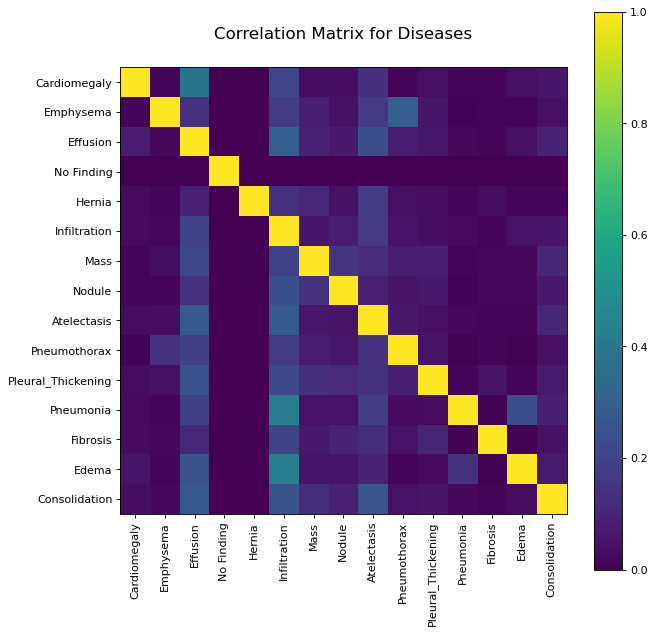

In [19]:
column = 'Finding Labels'
labels, matco = coOcurrencia(all_xray_df, column)
plotCorrelationMatrix(labels, matco, 9, title = 'Correlation Matrix for Diseases')

OBSERVATIONS: *From the previous correlation matrix we can observe that pneumonia is highly correlated with Infiltration. In second place it is correlated with Effusion and Edema.*

OBSERVACIONES: A partir de la matriz de correlación podemos observar que Neumonía esta altamente correlacionada con Infiltración, en segundo lugar está correlacionada con Effusion y con Edema.

##  Imágenes de Ejemplo


Leeremos un conjunto reducido de imágenes para poder analizarlas

In [20]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
print('Sample data leght:', len(sample_df))

sample_df.sample(10)


Sample data leght: 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1725,00009051_002.png,No Finding,2,9051,040Y,F,PA,2992,2991,0.143000,0.143000
1519,00007932_011.png,No Finding,11,7932,052Y,M,AP,2500,2048,0.168000,0.168000
747,00003917_000.png,No Finding,0,3917,063Y,F,PA,2048,2500,0.171000,0.171000
5445,00029597_003.png,Atelectasis|Effusion|Infiltration,3,29597,071Y,M,PA,2021,2021,0.194311,0.194311
3887,00019150_008.png,Infiltration,8,19150,069Y,M,AP,3056,2544,0.139000,0.139000
1944,00010120_004.png,No Finding,4,10120,049Y,M,PA,2814,2991,0.143000,0.143000
4967,00026179_005.png,Infiltration,5,26179,026Y,F,PA,2992,2991,0.143000,0.143000
3067,00015101_000.png,Nodule,0,15101,068Y,F,PA,2500,2048,0.168000,0.168000
5248,00028156_000.png,Mass|Pleural_Thickening,0,28156,017Y,M,AP,3056,2544,0.139000,0.139000
2728,00013670_050.png,Infiltration,50,13670,056Y,M,AP,2500,2048,0.168000,0.168000


### Pixel level information

In [21]:
# Again we will see the data
print(os.listdir('./'))

['test5.dcm', 'prc.png', 'my_model.json', 'FDA_Submission_Template.md', 'Build and train model.ipynb', 'xray_class_my_model.best.hdf5', '.ipynb_checkpoints', 'edaflow.PNG', 'roc.png', 'test4.dcm', 'sample_labels.csv', 'Inference.ipynb', 'test6.dcm', 'FDA_Submission_Vasquez.ipynb', 'vgg16.png', 'test2.dcm', 'test3.dcm', 'EDA.ipynb', 'myfiles.tar.gz', 'output_20_0.png', 'test1.dcm', 'xray.png']


In [22]:
# Read the DICOM's pixel_array attribute into a dataframe using the pydicom.dcmread function
dcm = pydicom.dcmread('test1.dcm')

Tipo de dato de las imágenes: <class 'numpy.uint8'>


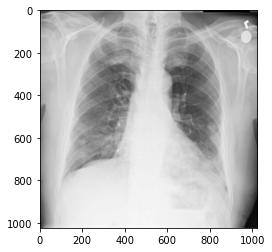

In [24]:
print('Tipo de dato de las imágenes:', type(dcm.pixel_array[0][0]))
# visualize the image
plt.imshow(dcm.pixel_array,cmap='gray')

In [25]:
# Agregar una columna que sea el path
sample_df_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data', 'images*', '*', '*.png'))}
sample_df['path'] = sample_df['Image Index'].map(sample_df_paths.get)
sample_df.sample(3, random_state=random_state)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2146,00011065_007.png,No Finding,7,11065,066Y,M,PA,2992,2991,0.143,0.143,/data/images_005/images/00011065_007.png
1879,00009892_001.png,No Finding,1,9892,062Y,F,PA,2992,2991,0.143,0.143,/data/images_005/images/00009892_001.png
346,00001836_076.png,Mass|Nodule,76,1836,050Y,F,AP,2500,2048,0.168,0.168,/data/images_002/images/00001836_076.png


In [26]:
sample_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
for name in sample_labels:
    sample_df[name] = sample_df['Finding Labels'].map(lambda finding: 1.0 if name in finding else 0)
    print('%s: %d'%(name, int(sample_df[name].sum())))

Atelectasis: 508
Cardiomegaly: 141
Consolidation: 226
Edema: 118
Effusion: 644
Emphysema: 127
Fibrosis: 84
Hernia: 13
Infiltration: 967
Mass: 284
No Finding: 3044
Nodule: 313
Pleural_Thickening: 176
Pneumonia: 62
Pneumothorax: 271


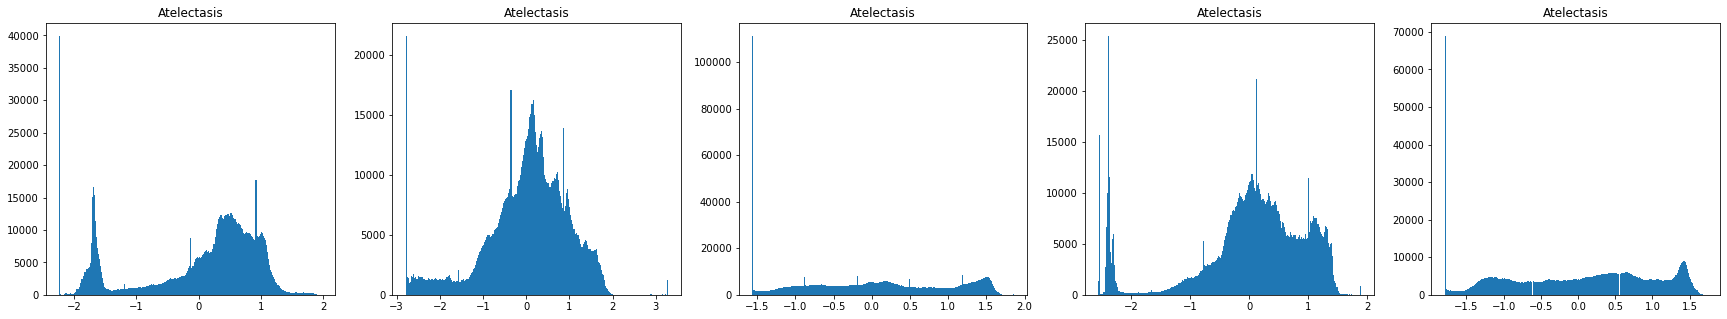

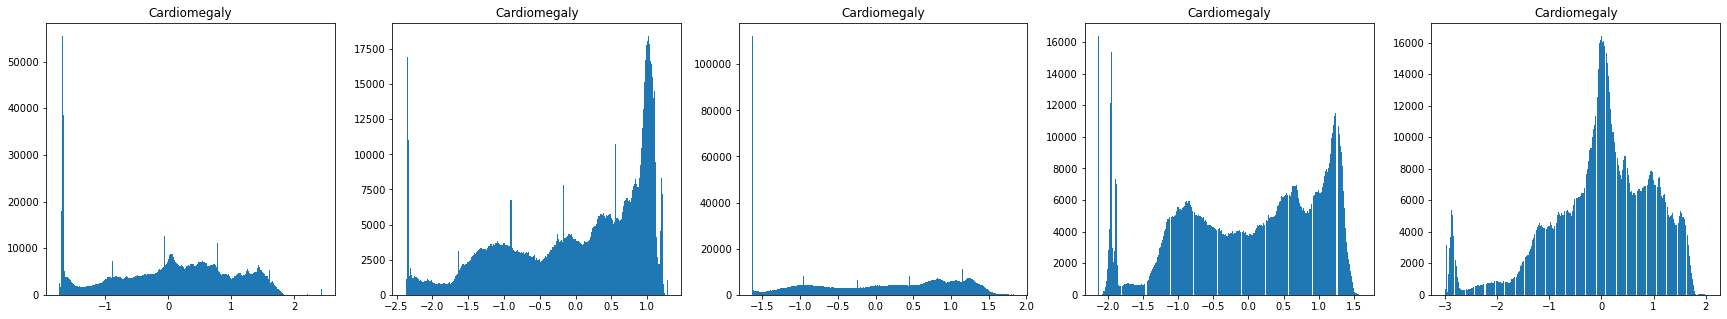

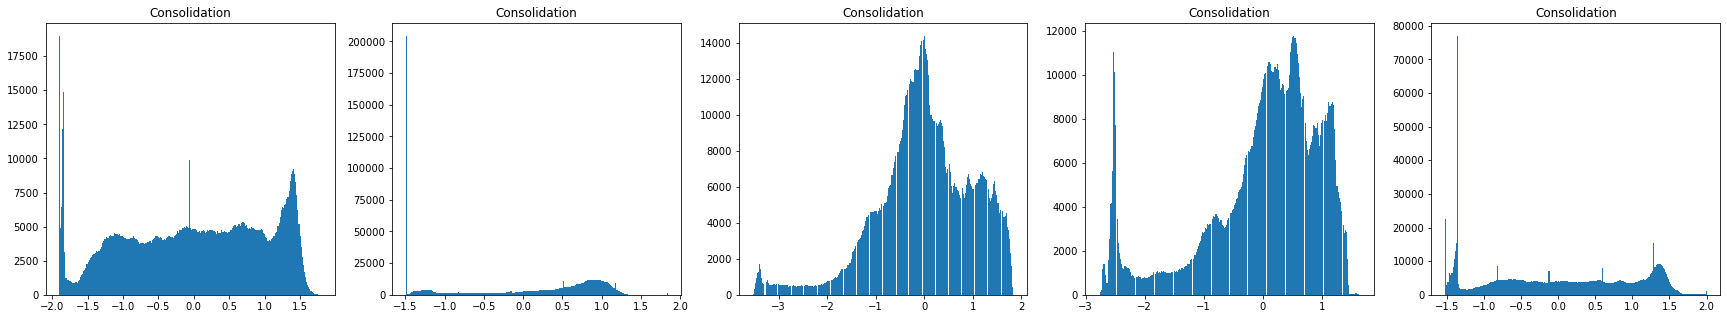

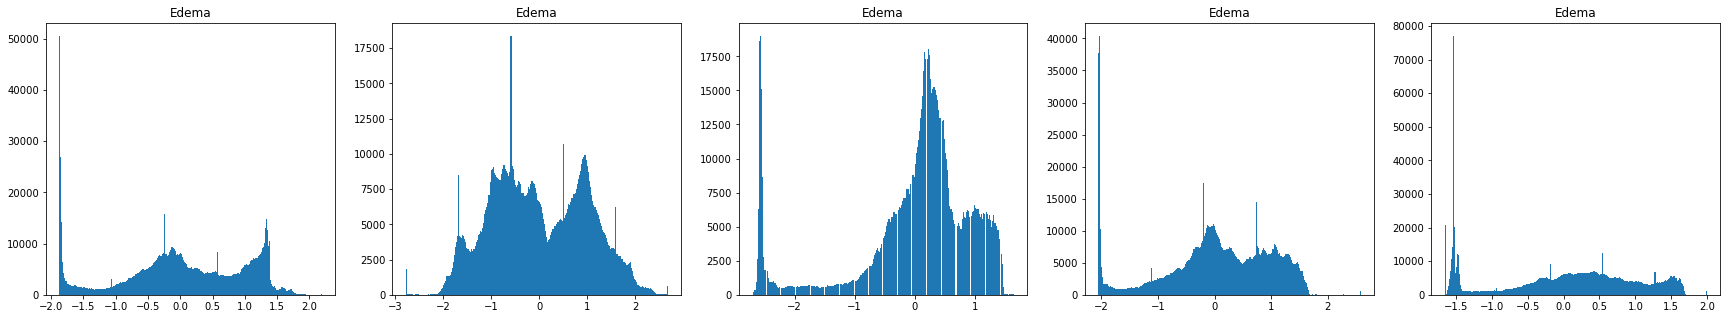

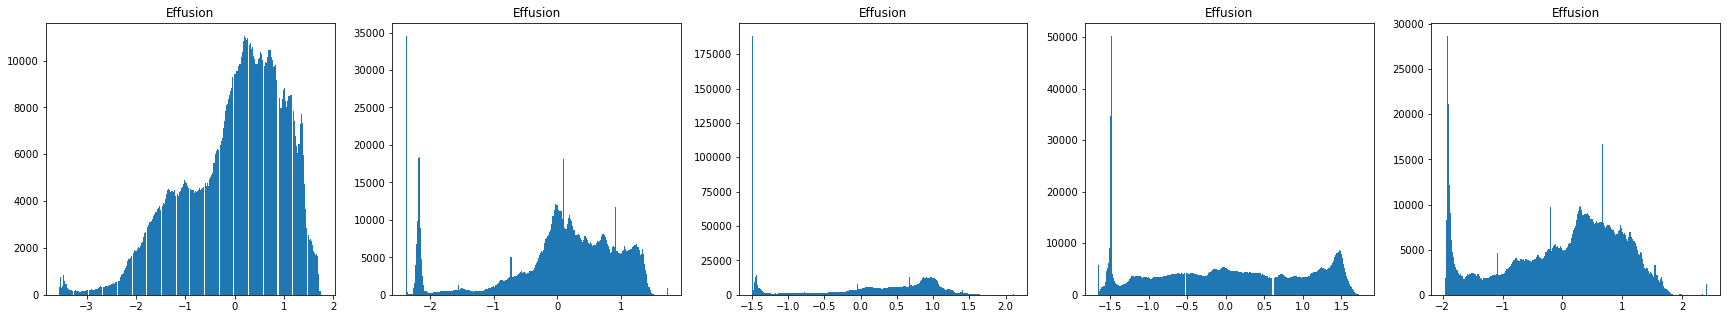

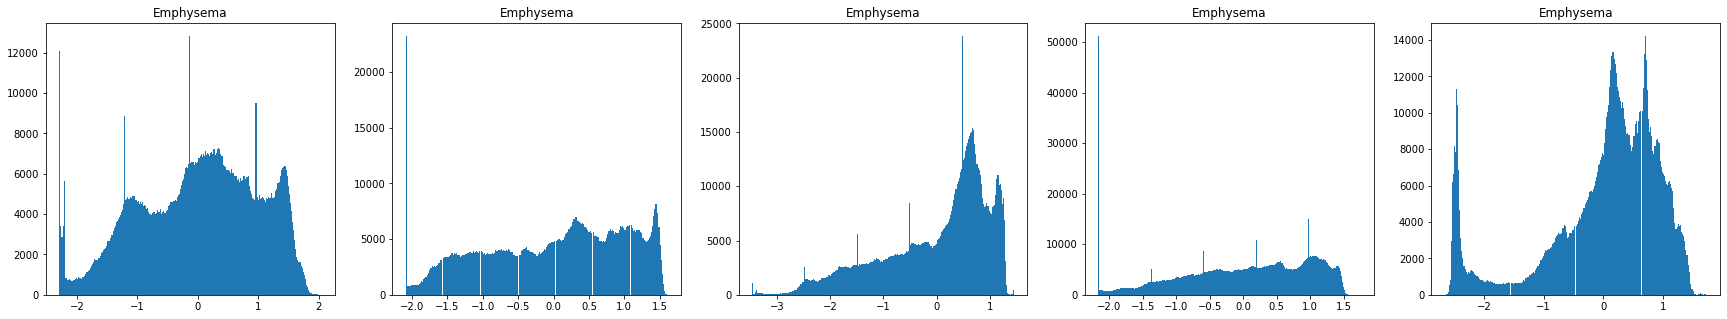

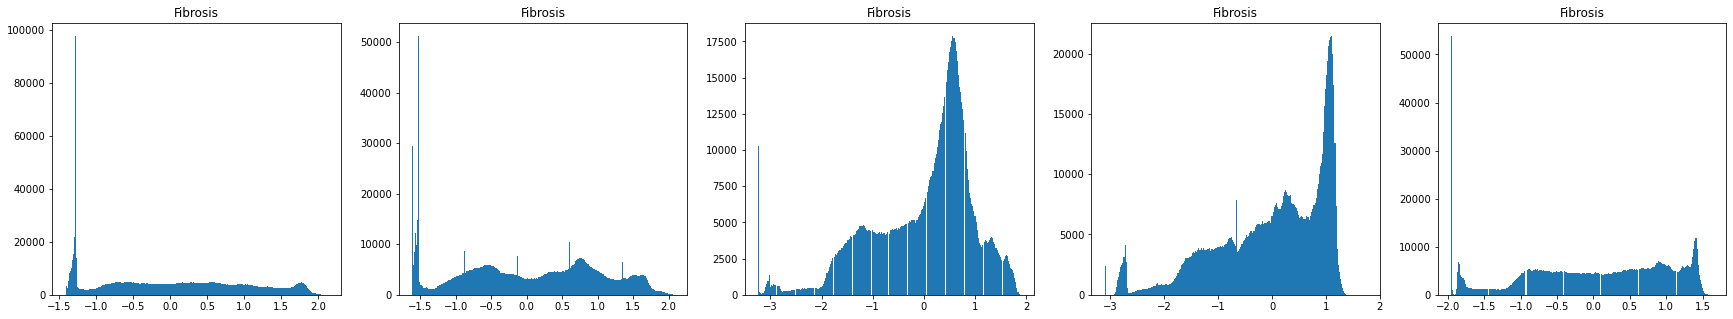

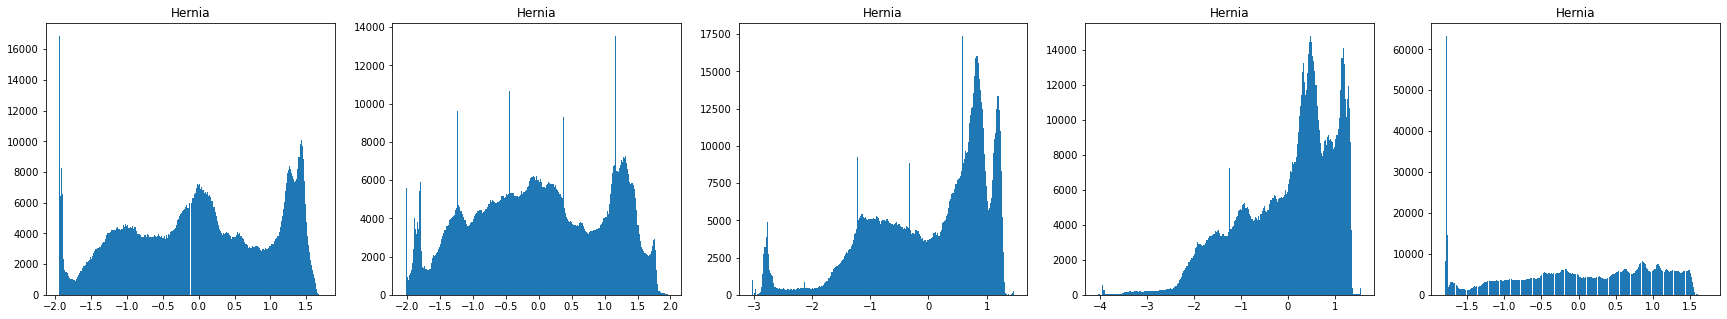

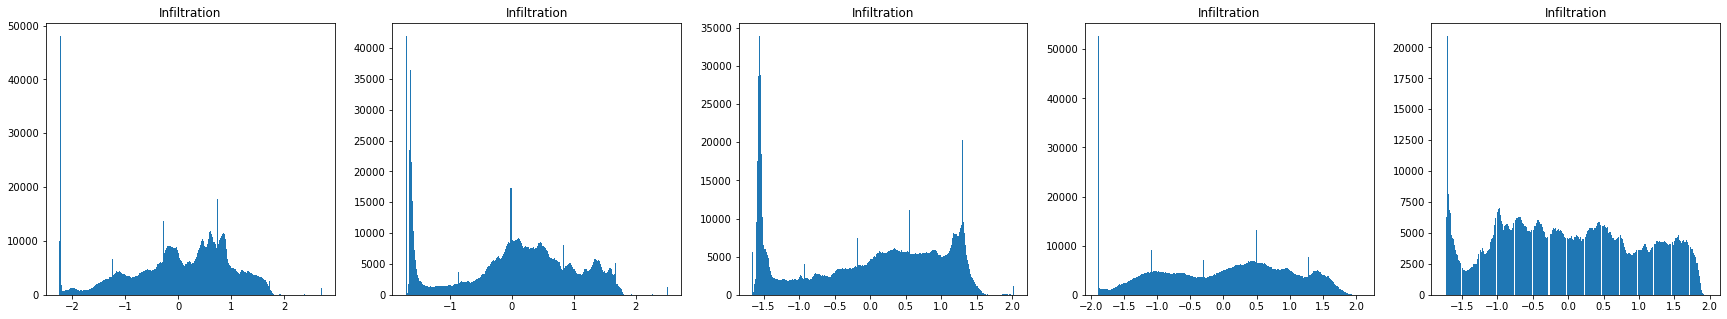

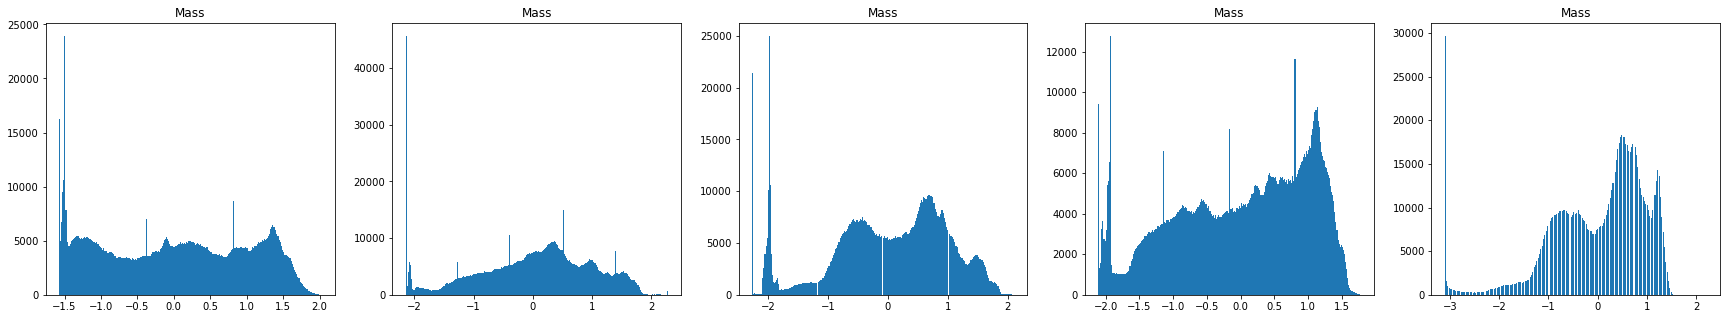

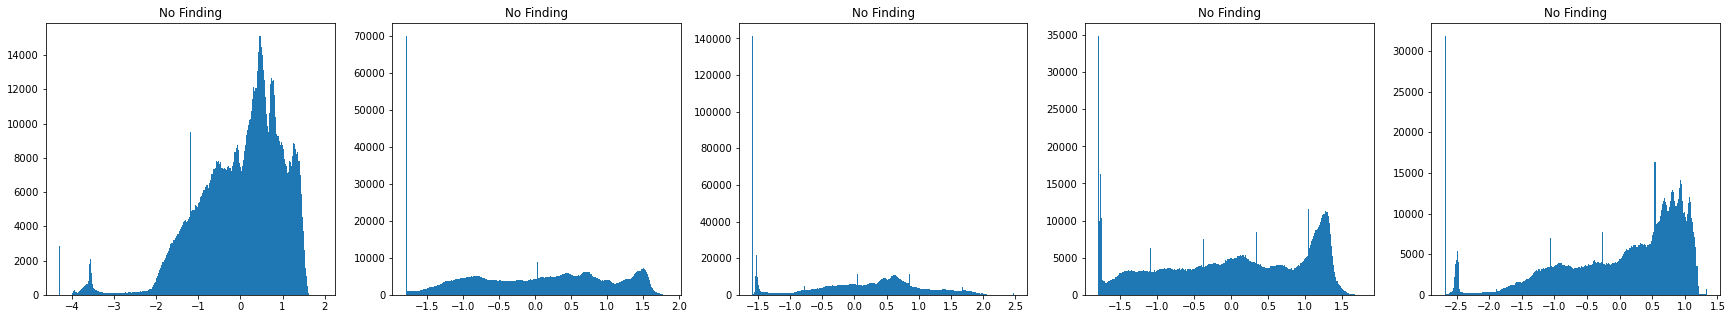

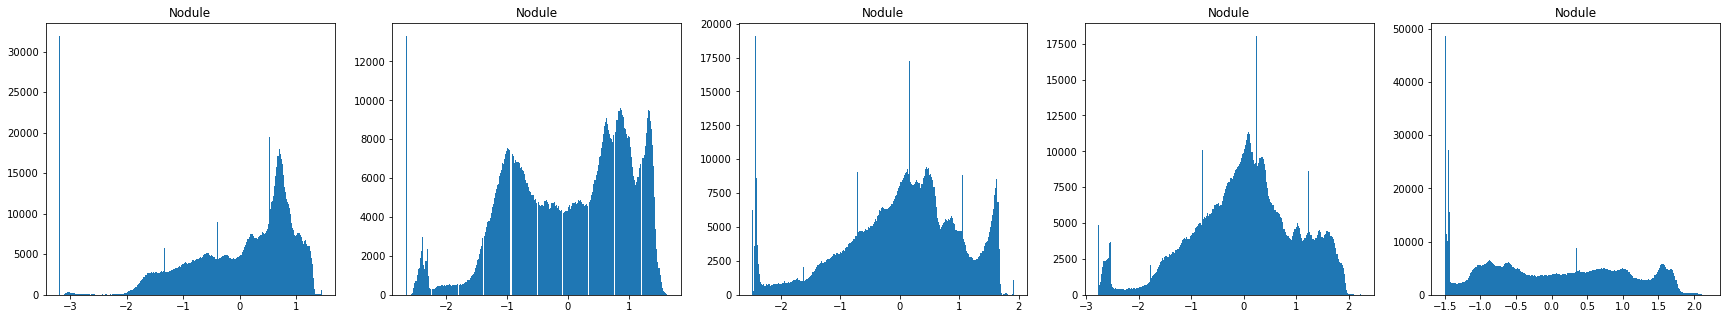

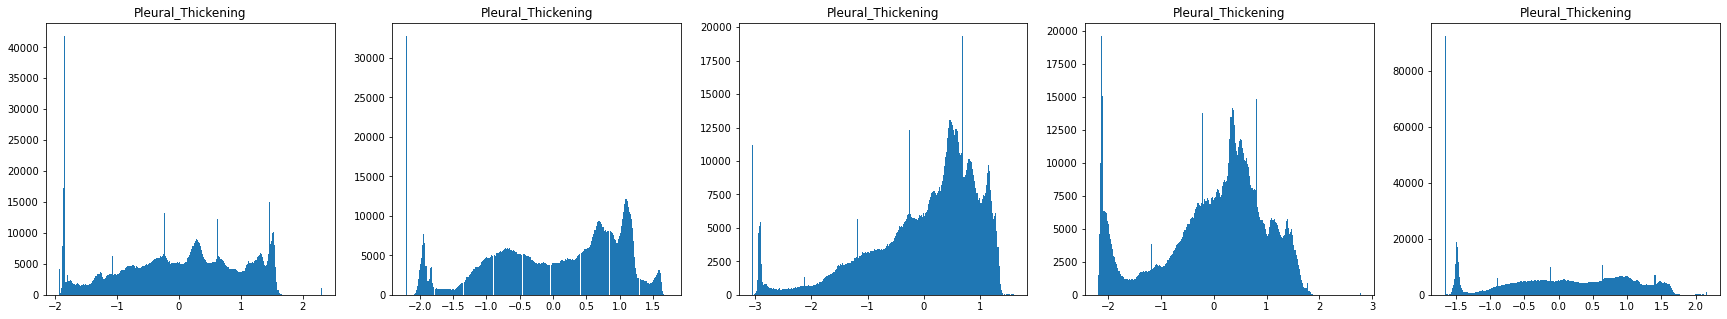

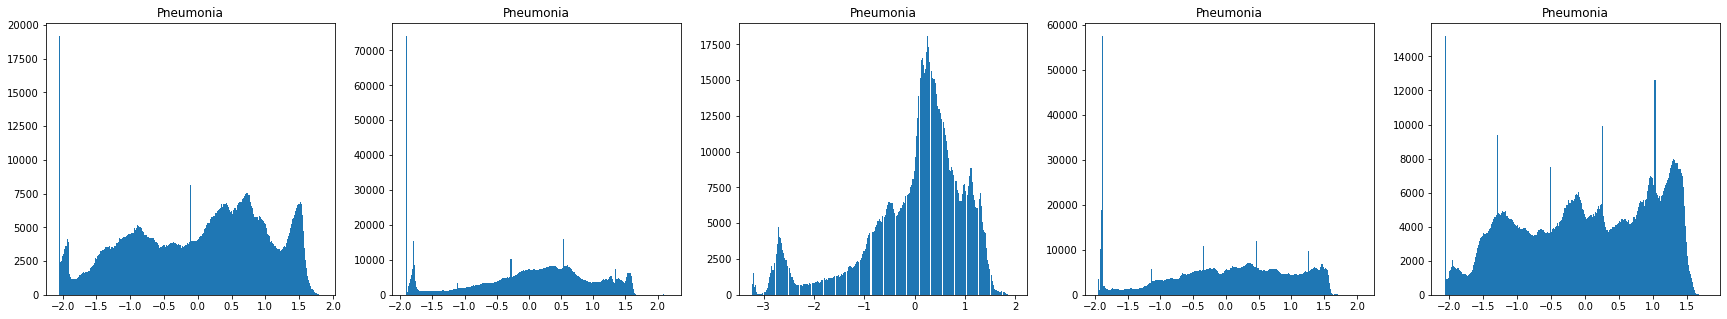

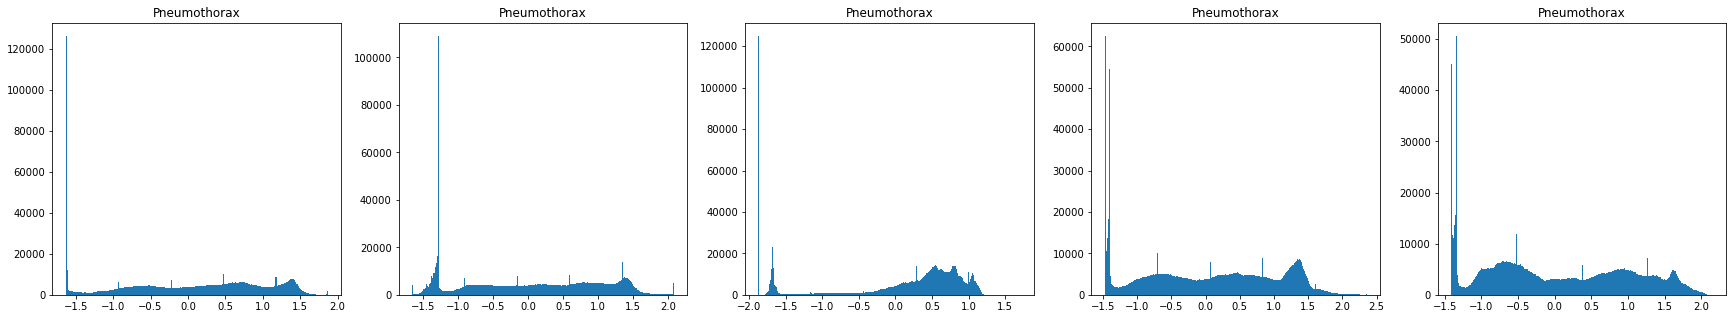

In [27]:
for name in sample_labels:
    img_path = sample_df[sample_df["Finding Labels"] == name].sample(5, random_state=random_state)["path"]
    plt.figure(figsize = (30, 5))
    for i in range(len(img_path)):
        plt.subplot(1, len(img_path), i + 1).set_title(name)
        var = plt.imread(img_path.iloc[i])
        plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

*OBSERVATIONS: Histograms do not show a clear pattern for the same disease. Therefore, histograms are not enough for classification. More features should be taken into account. For example spatial features.  In addition, some peaks for certain pixel values are found, those peaks seem to occur in random values, this support the need of computing more features.*

OBSERVACIONES: Los histogramas no muestran patrones claros entre enfermdades. Adicionalmente, algunos picos en la frecuencia aparecen de forma aleatoria. Por lo cual es necesario calcular más características en las imágenes, por ejemplo, características espaciales. 

### Conclusions

Some of the conclusions we can found after performing the EDA are:

- The age distribution is similar to a normal distribution, where the mean is close to 50 years hold. This implies that the algoritms that use this data probably will work better for patiend with an age close to the mean age.
- The data is almost balanced in terms of patient genre. Therefore, the training and metrics shoud work properly for both genres. 
- The amount of pneumonia examples is much less with respect to the whole dataset. They are only 1431.
- Classes as imbalanced in terms of findings, the majoritary class of 'no findings' can be more than ten times the number of examples from the pneumonia class. Therefore, we have to some techniques for adrressing the umbalanced problem, for example, at training stage, a balanced sub-dataset can be made using subsampling. 
- The correlation matrix shows that pneumonia is correlated with infiltration, this information could be used to improve the detection of pneumonia if infiltration is present. 
- With respect to pixel information, histograms can vary between images, a histogram equalization can be made, - however, this preprocessing must be validated by the accuracy reached.


## References

 - Cox V. (2017) Exploratory Data Analysis. In: Translating Statistics to Make Decisions. Apress, Berkeley, CA. https://doi.org/10.1007/978-1-4842-2256-0_3
